# Conditional GAN으로 생성 컨트롤하기

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [4]:
# Fashion MNIST digits dataset
trainset = datasets.FashionMNIST('./.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ]))
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True)

In [5]:
def one_hot_embedding(labels, num_classes):
    y = torch.eye(num_classes) 
    return y[labels]

In [6]:
# Discriminator
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

In [7]:
# Generator 
G = nn.Sequential(
        nn.Linear(64 + 10, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

In [8]:

# Device setting
D = D.to(DEVICE)
G = G.to(DEVICE)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [9]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, label) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        class_label = one_hot_embedding(label, 10).to(DEVICE)
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        
        generator_input = torch.cat([z, class_label], 1)
        
        fake_images= G(generator_input)

        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator

        # Compute loss with fake images
        fake_images = G(generator_input)
        outputs = D(fake_images)
        
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch,
                          EPOCHS,
                          i+1,
                          total_step,
                          d_loss.item(),
                          g_loss.item(), 
                          real_score.mean().item(),
                          fake_score.mean().item()))

Epoch [0/300], Step [200/600], d_loss: 0.0643, g_loss: 4.2080, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.1066, g_loss: 4.7353, D(x): 0.97, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0813, g_loss: 3.2918, D(x): 0.99, D(G(z)): 0.07
Epoch [1/300], Step [200/600], d_loss: 0.0823, g_loss: 4.5168, D(x): 0.98, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.0611, g_loss: 4.0944, D(x): 0.98, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.0387, g_loss: 5.6077, D(x): 1.00, D(G(z)): 0.03
Epoch [2/300], Step [200/600], d_loss: 0.0568, g_loss: 4.6148, D(x): 0.99, D(G(z)): 0.04
Epoch [2/300], Step [400/600], d_loss: 0.0892, g_loss: 5.8683, D(x): 0.96, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0260, g_loss: 5.3894, D(x): 0.99, D(G(z)): 0.02
Epoch [3/300], Step [200/600], d_loss: 0.1026, g_loss: 4.8952, D(x): 0.96, D(G(z)): 0.02
Epoch [3/300], Step [400/600], d_loss: 0.0236, g_loss: 6.5756, D(x): 0.99, D(G(z)): 0.01
Epoch [3/300], Step [

Epoch [30/300], Step [600/600], d_loss: 0.6143, g_loss: 3.3473, D(x): 0.87, D(G(z)): 0.16
Epoch [31/300], Step [200/600], d_loss: 0.4368, g_loss: 2.7986, D(x): 0.87, D(G(z)): 0.17
Epoch [31/300], Step [400/600], d_loss: 0.7080, g_loss: 3.0808, D(x): 0.77, D(G(z)): 0.16
Epoch [31/300], Step [600/600], d_loss: 0.4993, g_loss: 2.4426, D(x): 0.86, D(G(z)): 0.21
Epoch [32/300], Step [200/600], d_loss: 0.4674, g_loss: 3.0917, D(x): 0.90, D(G(z)): 0.20
Epoch [32/300], Step [400/600], d_loss: 0.5979, g_loss: 2.8374, D(x): 0.86, D(G(z)): 0.19
Epoch [32/300], Step [600/600], d_loss: 0.4931, g_loss: 3.0318, D(x): 0.84, D(G(z)): 0.16
Epoch [33/300], Step [200/600], d_loss: 0.6732, g_loss: 2.0539, D(x): 0.83, D(G(z)): 0.20
Epoch [33/300], Step [400/600], d_loss: 0.7276, g_loss: 2.5877, D(x): 0.77, D(G(z)): 0.18
Epoch [33/300], Step [600/600], d_loss: 0.5087, g_loss: 2.2576, D(x): 0.87, D(G(z)): 0.20
Epoch [34/300], Step [200/600], d_loss: 0.7042, g_loss: 2.6732, D(x): 0.77, D(G(z)): 0.16
Epoch [34/

Epoch [61/300], Step [400/600], d_loss: 0.8195, g_loss: 1.9345, D(x): 0.79, D(G(z)): 0.31
Epoch [61/300], Step [600/600], d_loss: 0.9477, g_loss: 2.0402, D(x): 0.65, D(G(z)): 0.20
Epoch [62/300], Step [200/600], d_loss: 0.5692, g_loss: 2.8328, D(x): 0.78, D(G(z)): 0.14
Epoch [62/300], Step [400/600], d_loss: 0.6348, g_loss: 2.4718, D(x): 0.76, D(G(z)): 0.20
Epoch [62/300], Step [600/600], d_loss: 0.7032, g_loss: 2.3737, D(x): 0.80, D(G(z)): 0.23
Epoch [63/300], Step [200/600], d_loss: 0.6831, g_loss: 2.5977, D(x): 0.77, D(G(z)): 0.22
Epoch [63/300], Step [400/600], d_loss: 0.7955, g_loss: 1.8043, D(x): 0.82, D(G(z)): 0.33
Epoch [63/300], Step [600/600], d_loss: 0.6617, g_loss: 1.9276, D(x): 0.82, D(G(z)): 0.26
Epoch [64/300], Step [200/600], d_loss: 0.5111, g_loss: 2.2696, D(x): 0.81, D(G(z)): 0.17
Epoch [64/300], Step [400/600], d_loss: 0.6663, g_loss: 2.4031, D(x): 0.80, D(G(z)): 0.21
Epoch [64/300], Step [600/600], d_loss: 0.9960, g_loss: 1.7233, D(x): 0.71, D(G(z)): 0.30
Epoch [65/

Epoch [92/300], Step [200/600], d_loss: 0.7614, g_loss: 1.9562, D(x): 0.80, D(G(z)): 0.29
Epoch [92/300], Step [400/600], d_loss: 0.8586, g_loss: 1.7819, D(x): 0.78, D(G(z)): 0.36
Epoch [92/300], Step [600/600], d_loss: 0.9219, g_loss: 1.6487, D(x): 0.73, D(G(z)): 0.34
Epoch [93/300], Step [200/600], d_loss: 1.0154, g_loss: 1.8335, D(x): 0.70, D(G(z)): 0.34
Epoch [93/300], Step [400/600], d_loss: 0.7342, g_loss: 1.9633, D(x): 0.76, D(G(z)): 0.28
Epoch [93/300], Step [600/600], d_loss: 0.7824, g_loss: 2.1372, D(x): 0.69, D(G(z)): 0.19
Epoch [94/300], Step [200/600], d_loss: 0.7138, g_loss: 1.8327, D(x): 0.73, D(G(z)): 0.24
Epoch [94/300], Step [400/600], d_loss: 0.8434, g_loss: 1.8555, D(x): 0.70, D(G(z)): 0.25
Epoch [94/300], Step [600/600], d_loss: 0.7385, g_loss: 2.4625, D(x): 0.74, D(G(z)): 0.20
Epoch [95/300], Step [200/600], d_loss: 0.9106, g_loss: 1.5145, D(x): 0.76, D(G(z)): 0.35
Epoch [95/300], Step [400/600], d_loss: 0.8550, g_loss: 2.0045, D(x): 0.80, D(G(z)): 0.35
Epoch [95/

Epoch [122/300], Step [400/600], d_loss: 0.9792, g_loss: 1.4449, D(x): 0.66, D(G(z)): 0.31
Epoch [122/300], Step [600/600], d_loss: 0.8501, g_loss: 1.6399, D(x): 0.71, D(G(z)): 0.28
Epoch [123/300], Step [200/600], d_loss: 1.2623, g_loss: 1.4890, D(x): 0.67, D(G(z)): 0.40
Epoch [123/300], Step [400/600], d_loss: 1.0200, g_loss: 1.3197, D(x): 0.68, D(G(z)): 0.37
Epoch [123/300], Step [600/600], d_loss: 0.9505, g_loss: 1.8150, D(x): 0.67, D(G(z)): 0.27
Epoch [124/300], Step [200/600], d_loss: 0.7861, g_loss: 1.7631, D(x): 0.70, D(G(z)): 0.25
Epoch [124/300], Step [400/600], d_loss: 0.9648, g_loss: 1.5262, D(x): 0.68, D(G(z)): 0.30
Epoch [124/300], Step [600/600], d_loss: 1.0604, g_loss: 1.5040, D(x): 0.67, D(G(z)): 0.32
Epoch [125/300], Step [200/600], d_loss: 1.0363, g_loss: 1.3299, D(x): 0.67, D(G(z)): 0.37
Epoch [125/300], Step [400/600], d_loss: 0.6692, g_loss: 2.3771, D(x): 0.73, D(G(z)): 0.17
Epoch [125/300], Step [600/600], d_loss: 0.9881, g_loss: 1.6018, D(x): 0.70, D(G(z)): 0.33

Epoch [152/300], Step [600/600], d_loss: 1.0832, g_loss: 1.5234, D(x): 0.63, D(G(z)): 0.33
Epoch [153/300], Step [200/600], d_loss: 0.9163, g_loss: 1.8132, D(x): 0.66, D(G(z)): 0.28
Epoch [153/300], Step [400/600], d_loss: 1.0529, g_loss: 1.6222, D(x): 0.65, D(G(z)): 0.31
Epoch [153/300], Step [600/600], d_loss: 0.9976, g_loss: 1.2325, D(x): 0.70, D(G(z)): 0.37
Epoch [154/300], Step [200/600], d_loss: 1.1766, g_loss: 1.3289, D(x): 0.71, D(G(z)): 0.40
Epoch [154/300], Step [400/600], d_loss: 0.9384, g_loss: 1.5112, D(x): 0.65, D(G(z)): 0.28
Epoch [154/300], Step [600/600], d_loss: 1.1660, g_loss: 1.6049, D(x): 0.55, D(G(z)): 0.28
Epoch [155/300], Step [200/600], d_loss: 0.8504, g_loss: 1.4514, D(x): 0.71, D(G(z)): 0.31
Epoch [155/300], Step [400/600], d_loss: 1.0115, g_loss: 1.4130, D(x): 0.67, D(G(z)): 0.34
Epoch [155/300], Step [600/600], d_loss: 1.0627, g_loss: 1.1687, D(x): 0.63, D(G(z)): 0.33
Epoch [156/300], Step [200/600], d_loss: 0.8713, g_loss: 1.4656, D(x): 0.70, D(G(z)): 0.30

Epoch [183/300], Step [200/600], d_loss: 1.0150, g_loss: 1.5329, D(x): 0.67, D(G(z)): 0.31
Epoch [183/300], Step [400/600], d_loss: 0.9868, g_loss: 1.4336, D(x): 0.72, D(G(z)): 0.34
Epoch [183/300], Step [600/600], d_loss: 0.9544, g_loss: 1.7054, D(x): 0.67, D(G(z)): 0.30
Epoch [184/300], Step [200/600], d_loss: 0.9311, g_loss: 1.7886, D(x): 0.65, D(G(z)): 0.24
Epoch [184/300], Step [400/600], d_loss: 0.6645, g_loss: 1.8206, D(x): 0.74, D(G(z)): 0.22
Epoch [184/300], Step [600/600], d_loss: 0.8231, g_loss: 1.4707, D(x): 0.70, D(G(z)): 0.30
Epoch [185/300], Step [200/600], d_loss: 1.1886, g_loss: 1.3244, D(x): 0.59, D(G(z)): 0.37
Epoch [185/300], Step [400/600], d_loss: 0.8258, g_loss: 1.5064, D(x): 0.72, D(G(z)): 0.31
Epoch [185/300], Step [600/600], d_loss: 1.3852, g_loss: 0.9955, D(x): 0.54, D(G(z)): 0.43
Epoch [186/300], Step [200/600], d_loss: 0.6803, g_loss: 1.7612, D(x): 0.72, D(G(z)): 0.22
Epoch [186/300], Step [400/600], d_loss: 1.0545, g_loss: 1.2251, D(x): 0.64, D(G(z)): 0.36

Epoch [213/300], Step [400/600], d_loss: 1.0729, g_loss: 1.3197, D(x): 0.63, D(G(z)): 0.34
Epoch [213/300], Step [600/600], d_loss: 0.8125, g_loss: 1.6972, D(x): 0.69, D(G(z)): 0.27
Epoch [214/300], Step [200/600], d_loss: 1.3824, g_loss: 1.1287, D(x): 0.55, D(G(z)): 0.39
Epoch [214/300], Step [400/600], d_loss: 0.8650, g_loss: 1.6486, D(x): 0.67, D(G(z)): 0.27
Epoch [214/300], Step [600/600], d_loss: 1.1019, g_loss: 1.3254, D(x): 0.62, D(G(z)): 0.33
Epoch [215/300], Step [200/600], d_loss: 0.9434, g_loss: 1.4564, D(x): 0.67, D(G(z)): 0.30
Epoch [215/300], Step [400/600], d_loss: 0.8527, g_loss: 1.6990, D(x): 0.68, D(G(z)): 0.26
Epoch [215/300], Step [600/600], d_loss: 0.8933, g_loss: 1.5153, D(x): 0.72, D(G(z)): 0.33
Epoch [216/300], Step [200/600], d_loss: 1.2165, g_loss: 1.2627, D(x): 0.61, D(G(z)): 0.39
Epoch [216/300], Step [400/600], d_loss: 0.7974, g_loss: 1.6402, D(x): 0.72, D(G(z)): 0.29
Epoch [216/300], Step [600/600], d_loss: 1.4808, g_loss: 1.0476, D(x): 0.58, D(G(z)): 0.46

Epoch [243/300], Step [600/600], d_loss: 1.2101, g_loss: 1.2876, D(x): 0.60, D(G(z)): 0.37
Epoch [244/300], Step [200/600], d_loss: 0.8011, g_loss: 1.4786, D(x): 0.73, D(G(z)): 0.32
Epoch [244/300], Step [400/600], d_loss: 1.0197, g_loss: 1.4902, D(x): 0.67, D(G(z)): 0.34
Epoch [244/300], Step [600/600], d_loss: 0.9253, g_loss: 1.5408, D(x): 0.67, D(G(z)): 0.29
Epoch [245/300], Step [200/600], d_loss: 0.9080, g_loss: 1.7092, D(x): 0.70, D(G(z)): 0.30
Epoch [245/300], Step [400/600], d_loss: 0.8811, g_loss: 1.5260, D(x): 0.70, D(G(z)): 0.33
Epoch [245/300], Step [600/600], d_loss: 1.0933, g_loss: 1.7085, D(x): 0.63, D(G(z)): 0.31
Epoch [246/300], Step [200/600], d_loss: 0.9130, g_loss: 1.5585, D(x): 0.67, D(G(z)): 0.31
Epoch [246/300], Step [400/600], d_loss: 0.9626, g_loss: 1.4496, D(x): 0.68, D(G(z)): 0.30
Epoch [246/300], Step [600/600], d_loss: 0.8108, g_loss: 1.7658, D(x): 0.73, D(G(z)): 0.29
Epoch [247/300], Step [200/600], d_loss: 1.3616, g_loss: 1.1309, D(x): 0.63, D(G(z)): 0.44

Epoch [274/300], Step [200/600], d_loss: 1.5204, g_loss: 1.1162, D(x): 0.52, D(G(z)): 0.40
Epoch [274/300], Step [400/600], d_loss: 1.0966, g_loss: 1.3505, D(x): 0.65, D(G(z)): 0.37
Epoch [274/300], Step [600/600], d_loss: 0.9660, g_loss: 1.7065, D(x): 0.64, D(G(z)): 0.29
Epoch [275/300], Step [200/600], d_loss: 0.9355, g_loss: 1.3975, D(x): 0.68, D(G(z)): 0.32
Epoch [275/300], Step [400/600], d_loss: 0.8120, g_loss: 1.6395, D(x): 0.67, D(G(z)): 0.24
Epoch [275/300], Step [600/600], d_loss: 1.1307, g_loss: 1.2484, D(x): 0.68, D(G(z)): 0.40
Epoch [276/300], Step [200/600], d_loss: 0.9913, g_loss: 1.3487, D(x): 0.68, D(G(z)): 0.33
Epoch [276/300], Step [400/600], d_loss: 1.1902, g_loss: 1.0914, D(x): 0.67, D(G(z)): 0.42
Epoch [276/300], Step [600/600], d_loss: 1.0183, g_loss: 1.4218, D(x): 0.65, D(G(z)): 0.32
Epoch [277/300], Step [200/600], d_loss: 0.9580, g_loss: 1.1832, D(x): 0.75, D(G(z)): 0.41
Epoch [277/300], Step [400/600], d_loss: 1.0399, g_loss: 1.5804, D(x): 0.63, D(G(z)): 0.29

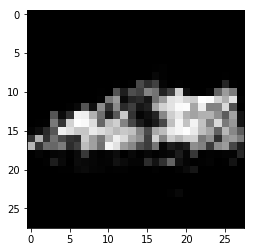

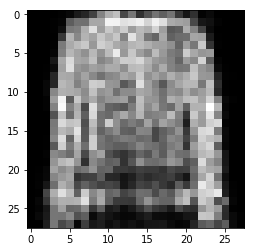

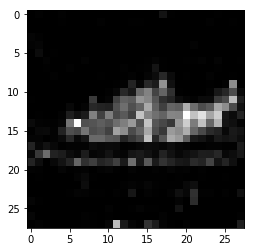

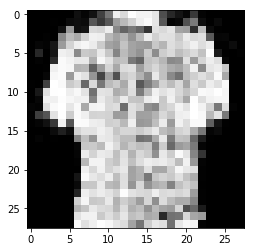

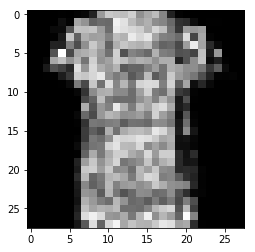

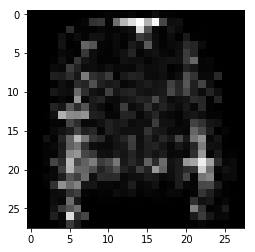

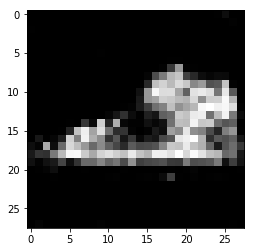

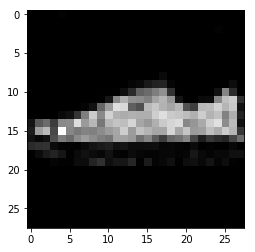

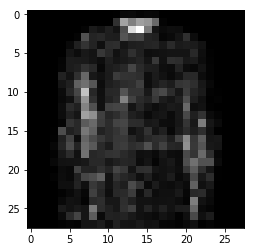

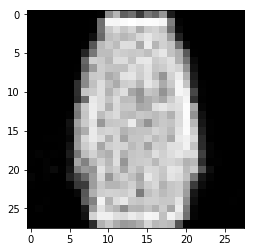

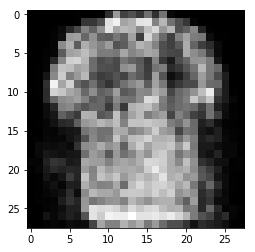

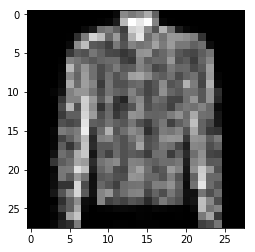

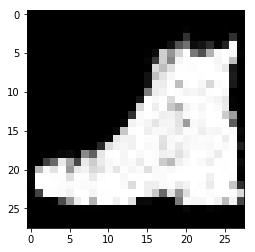

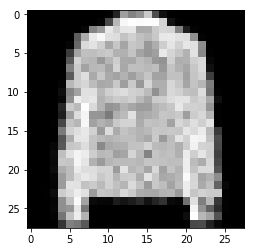

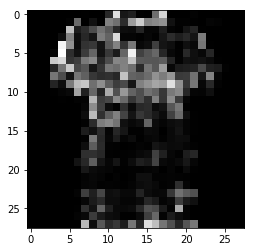

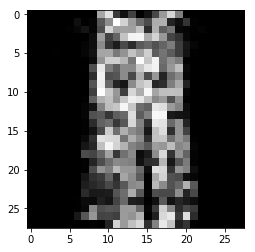

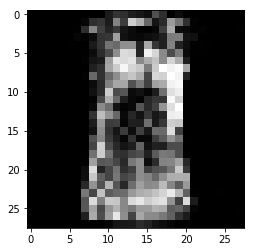

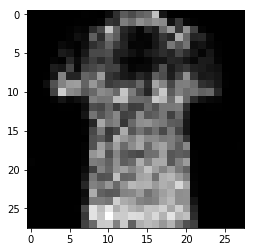

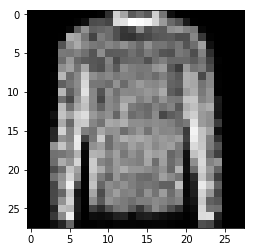

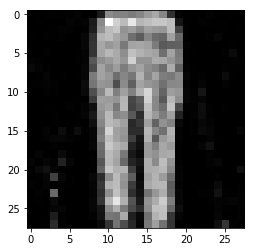

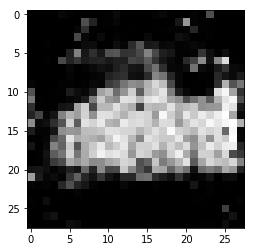

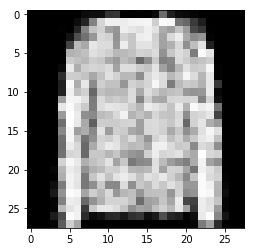

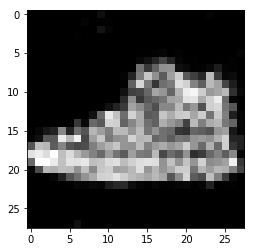

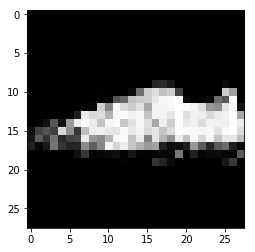

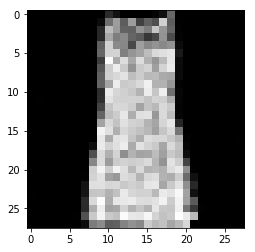

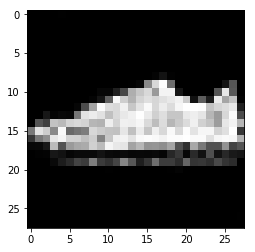

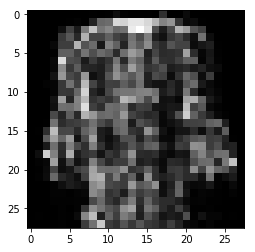

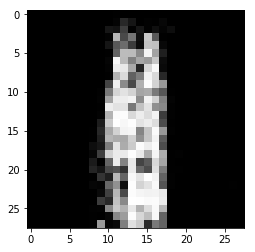

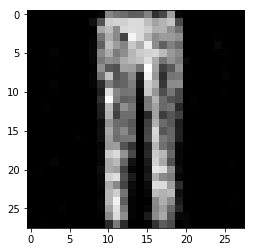

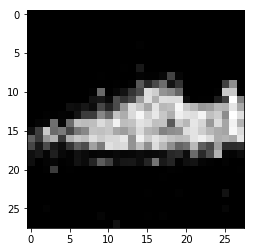

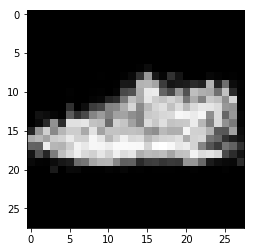

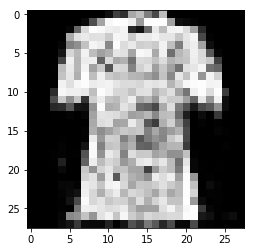

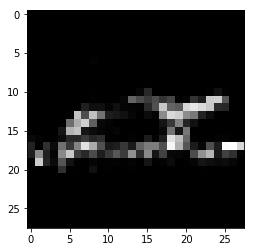

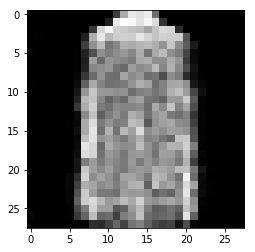

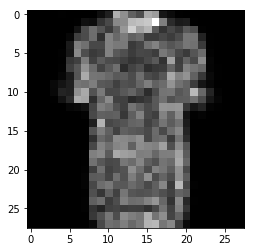

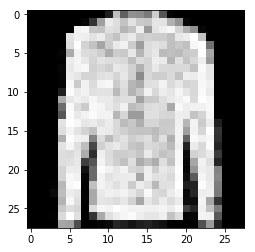

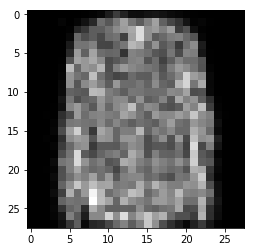

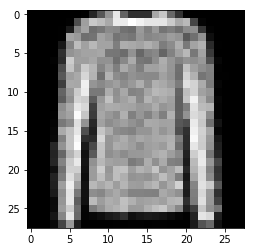

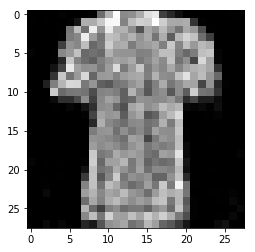

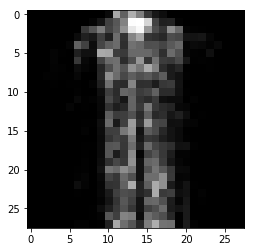

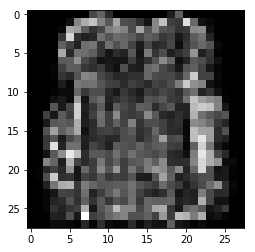

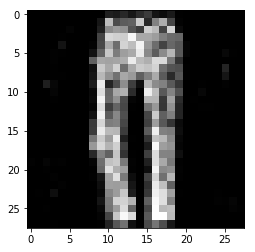

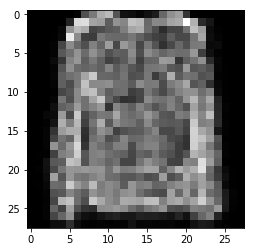

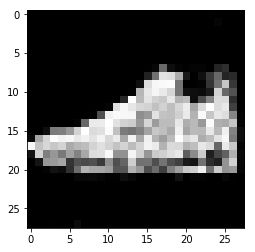

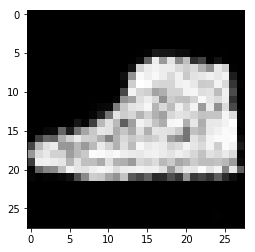

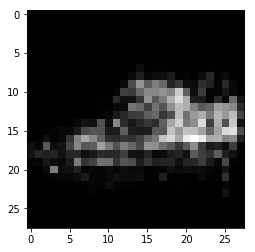

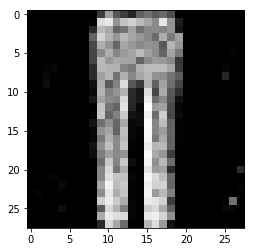

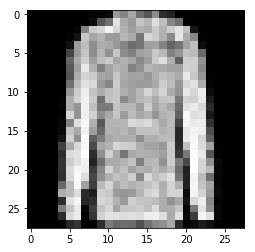

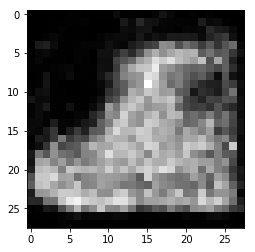

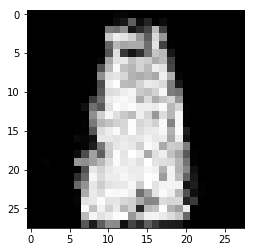

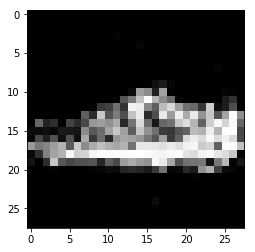

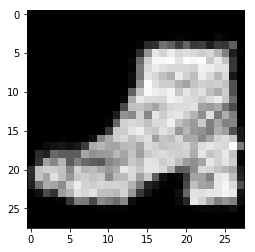

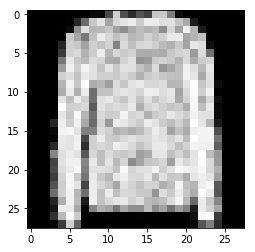

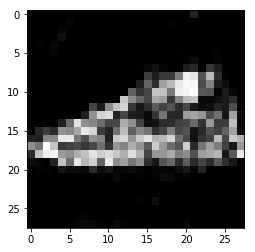

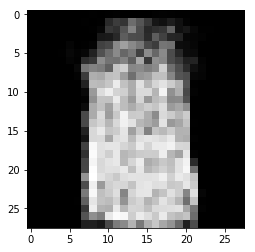

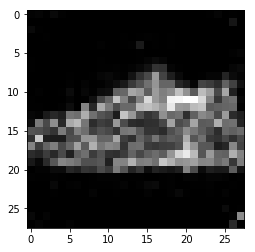

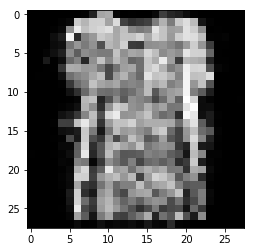

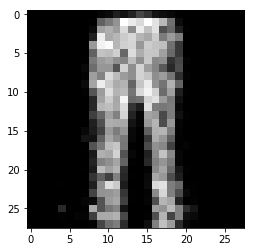

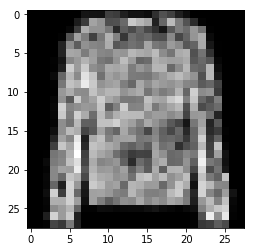

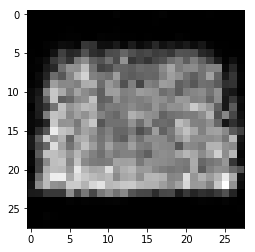

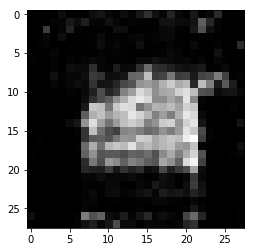

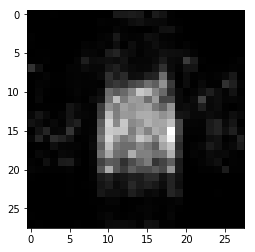

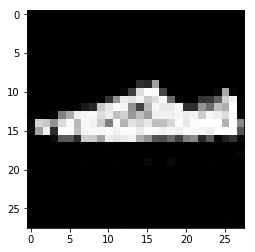

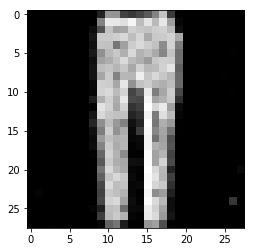

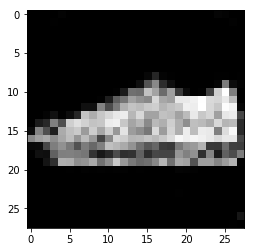

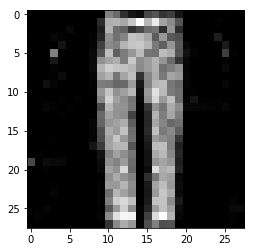

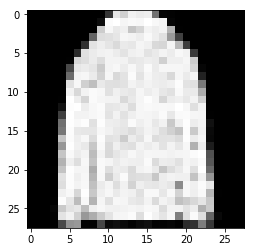

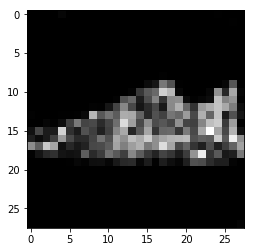

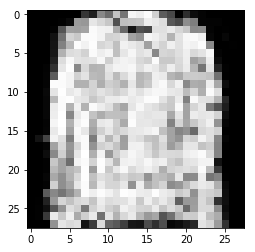

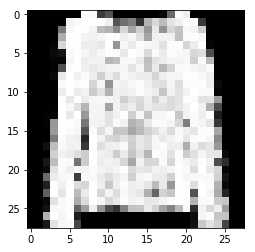

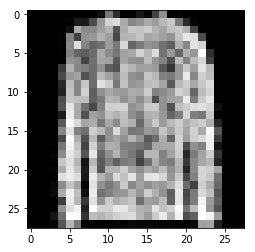

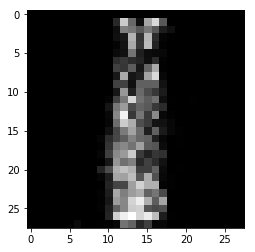

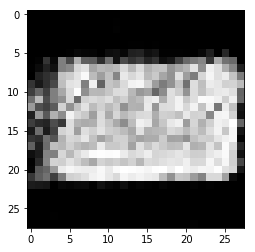

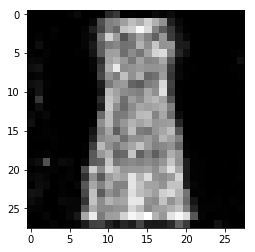

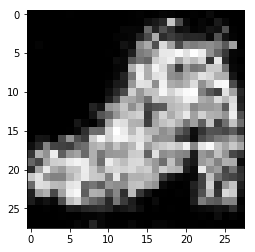

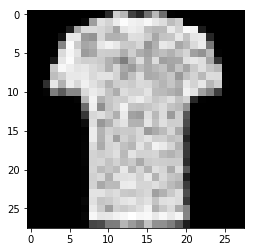

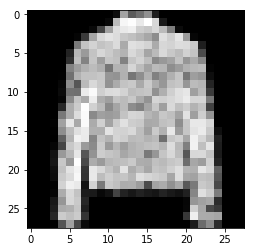

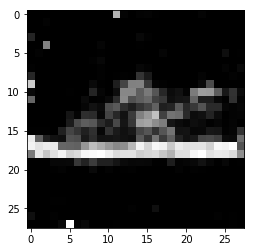

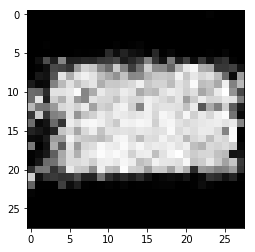

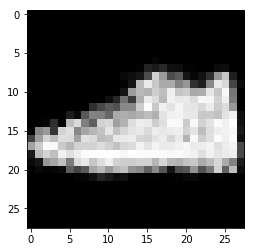

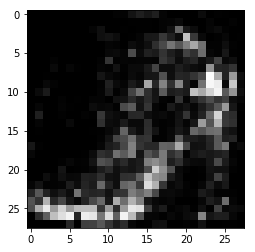

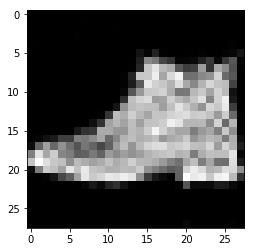

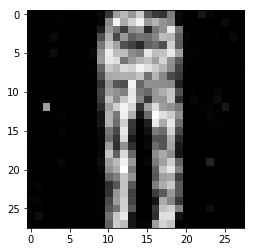

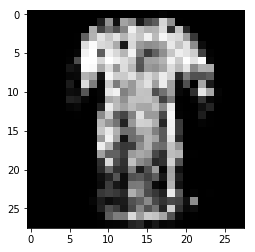

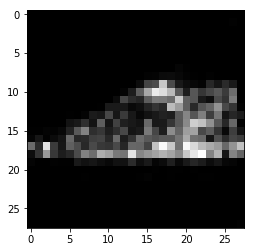

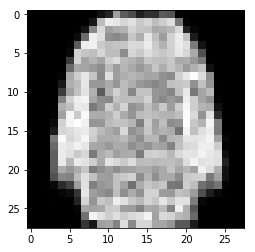

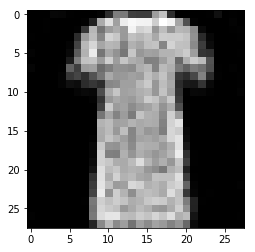

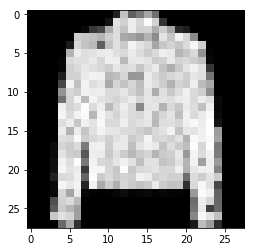

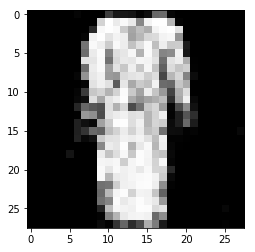

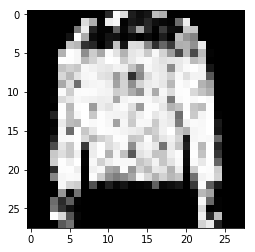

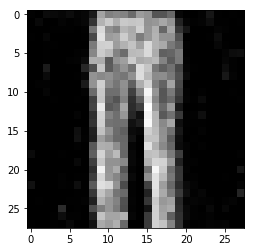

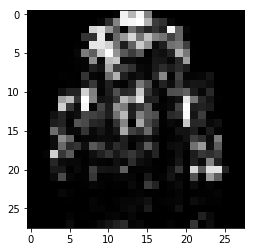

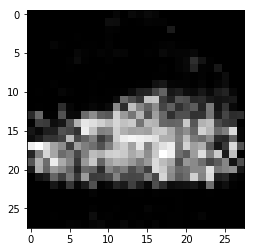

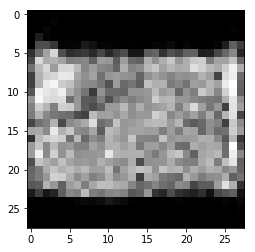

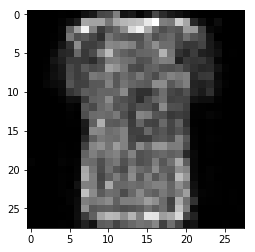

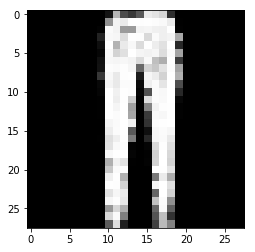

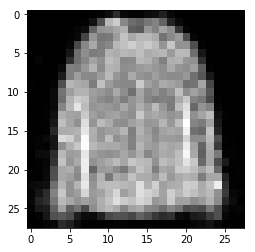

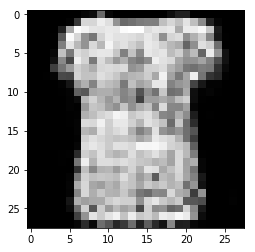

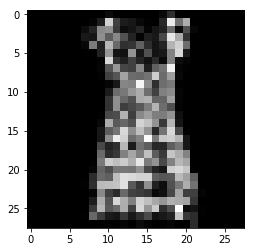

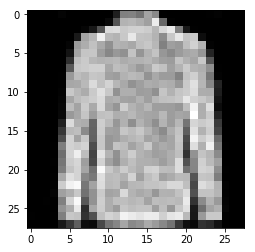

In [11]:
for i in range(100):
    label = torch.tensor([4])
    class_label = one_hot_embedding(label, 10).to(DEVICE)
    z = torch.randn(1, 64).to(DEVICE)
    generator_input = torch.cat([z, class_label], 1)
    fake_images= G(generator_input)
    fake_images = np.reshape(fake_images.cpu().data.numpy()[0],(28, 28))
    plt.imshow(fake_images, cmap = 'gray')
    plt.show()